In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import numpy as np

from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.5)

In [23]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)

# X_test = torch.FloatTensor(X_test)
# y_test = torch.FloatTensor(y_test).view(-1,1)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
# test_data = torch.utils.data.TensorDataset(X_test, y_test)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=500)

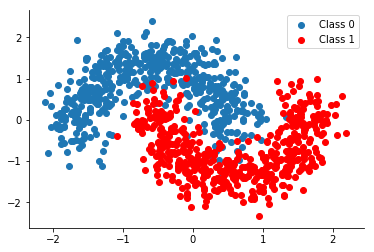

In [24]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()

In [25]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = torch.FloatTensor(grid.reshape(2, -1).T)
dummy_out = torch.tensor(np.ones(grid_2d.shape))

In [26]:
test_data = torch.utils.data.TensorDataset(grid_2d, dummy_out)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000)

In [27]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(2, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,2, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [31]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-1



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=True)

optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)

#evaluate = evaluation(test_loader, 4.5, X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_sgld = []
test_rmse = []
log_lik_sgld = []
n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)
                    
                    #accuracy = torch.sum(prediction.eq(y.long())).float() / 500
                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1
#            rmse, log_lik, predictions = evaluate.fn(network)

#                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
#            test_rmse.append(rmse)
#            log_lik_sgld.append(log_lik)
        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 0.4480
Epoch 1 - loss: 0.3228
Epoch 2 - loss: 0.3226
Epoch 3 - loss: 0.3255
Epoch 4 - loss: 0.3210
Epoch 5 - loss: 0.3228
Epoch 6 - loss: 0.3285
Epoch 7 - loss: 0.3134
Epoch 8 - loss: 0.2974
Epoch 9 - loss: 0.3047
Epoch 10 - loss: 0.2891
Epoch 11 - loss: 0.2668
Epoch 12 - loss: 0.2664
Epoch 13 - loss: 0.2500
Epoch 14 - loss: 0.1994
Epoch 15 - loss: 0.1888
Epoch 16 - loss: 0.1831
Epoch 17 - loss: 0.1628
Accuracy: 0.0000
Epoch 18 - loss: 0.1641


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy: 0.0000
Accuracy: 0.0000
Epoch 19 - loss: 0.1649
Accuracy: 0.0000
Epoch 20 - loss: 0.1789
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 21 - loss: 0.1498
Accuracy: 0.0000
Epoch 22 - loss: 0.1442
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 23 - loss: 0.1588
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 24 - loss: 0.1609
Accuracy: 0.0000
Epoch 25 - loss: 0.1504
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 26 - loss: 0.1386
Accuracy: 0.0000
Epoch 27 - loss: 0.1552
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 28 - loss: 0.1500
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 29 - loss: 0.1368
Accuracy: 0.0000
Epoch 30 - loss: 0.1361
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 31 - loss: 0.1481
Accuracy: 0.0000
Epoch 32 - loss: 0.1687
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 33 - loss: 0.1686
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 34 - loss: 0.1354
Accuracy: 0.0000
Epoch 35 - loss: 0.1665
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 36 - loss: 0.1417
Accuracy: 0.0000
Epoch 37 - loss: 0.1350
Accuracy: 0.0000
Accuracy: 0.0000


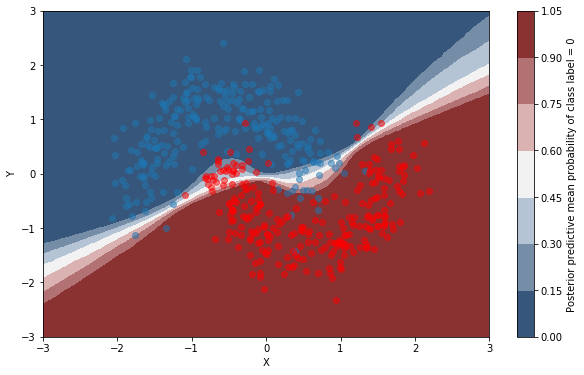

In [29]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

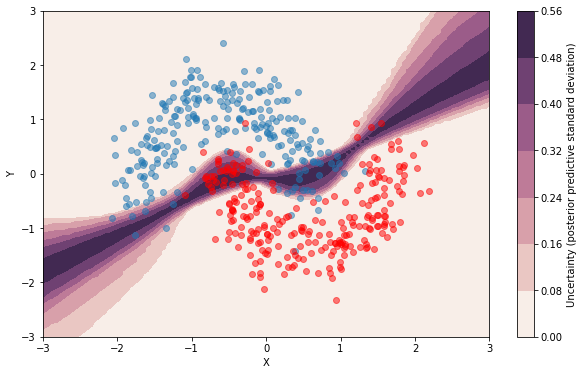

In [30]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [32]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-2
alpha = 0.99



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=True)

optim = psgld.optim.psgld(network, lr, alpha,lambda_, batch_size, dataset_size)

#evaluate = evaluation(test_loader, 4.5, X_train_mean, X_train_std, y_train_mean, y_train_std)

n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)
                    
                    #accuracy = torch.sum(prediction.eq(y.long())).float() / 500
                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1
#            rmse, log_lik, predictions = evaluate.fn(network)

#                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
#            test_rmse.append(rmse)
#            log_lik_sgld.append(log_lik)
        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 1.1169
Epoch 1 - loss: 0.3149
Epoch 2 - loss: 0.2700
Epoch 3 - loss: 0.2121
Epoch 4 - loss: 0.1772
Epoch 5 - loss: 0.1922
Epoch 6 - loss: 0.2418
Epoch 7 - loss: 0.1695
Epoch 8 - loss: 0.1679
Epoch 9 - loss: 0.1701
Epoch 10 - loss: 0.2662
Epoch 11 - loss: 0.1599
Epoch 12 - loss: 0.1660
Epoch 13 - loss: 0.1858
Epoch 14 - loss: 0.1785
Epoch 15 - loss: 0.2109
Epoch 16 - loss: 0.1739
Epoch 17 - loss: 0.1891


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy: 0.0000
Epoch 18 - loss: 0.2593
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 19 - loss: 0.2063
Accuracy: 0.0000
Epoch 20 - loss: 0.1963
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 21 - loss: 0.1715
Accuracy: 0.0000
Epoch 22 - loss: 0.1737
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 23 - loss: 0.1949
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 24 - loss: 0.2332
Accuracy: 0.0000
Epoch 25 - loss: 0.2176
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 26 - loss: 0.1950
Accuracy: 0.0000
Epoch 27 - loss: 0.1996
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 28 - loss: 0.2088
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 29 - loss: 0.2274
Accuracy: 0.0000
Epoch 30 - loss: 0.2179
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 31 - loss: 0.1775
Accuracy: 0.0000
Epoch 32 - loss: 0.2119
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 33 - loss: 0.1852
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 34 - loss: 0.2430
Accuracy: 0.0000
Epoch 35 - loss: 0.1606
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 36 - loss: 0.1673
Accuracy: 0.0000
Epoch 37 - loss: 

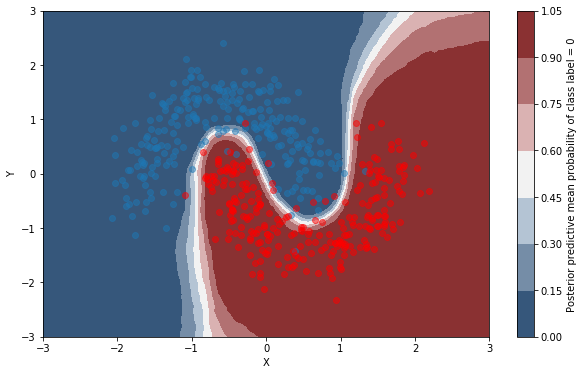

In [33]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

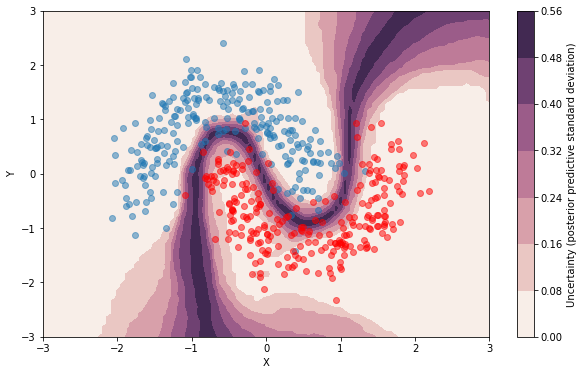

In [34]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [39]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-2



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon= 0.1, l2=1e-3, invert_every=1)




n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)
        
        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)

                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1

        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 0.7808
Epoch 1 - loss: 0.7769
Epoch 2 - loss: 0.7713
Epoch 3 - loss: 0.7654
Epoch 4 - loss: 0.7583
Epoch 5 - loss: 0.7512
Epoch 6 - loss: 0.7477
Epoch 7 - loss: 0.7446
Epoch 8 - loss: 0.7404
Epoch 9 - loss: 0.7353
Epoch 10 - loss: 0.7305
Epoch 11 - loss: 0.7268
Epoch 12 - loss: 0.7222
Epoch 13 - loss: 0.7200
Epoch 14 - loss: 0.7143
Epoch 15 - loss: 0.7091
Epoch 16 - loss: 0.7041
Epoch 17 - loss: 0.6998
Accuracy: 0.0000
Epoch 18 - loss: 0.6962
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 19 - loss: 0.6905
Accuracy: 0.0000
Epoch 20 - loss: 0.6859
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 21 - loss: 0.6812
Accuracy: 0.0000
Epoch 22 - loss: 0.6769
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 23 - loss: 0.6723
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 24 - loss: 0.6664
Accuracy: 0.0000
Epoch 25 - loss: 0.6641
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 26 - loss: 0.6619
Accuracy: 0.0000
Epoch 27 - loss: 0.6605
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 28 - loss: 0.6563
Accuracy: 0.0000
Accuracy

Epoch 197 - loss: 0.3760
Epoch 198 - loss: 0.3757
Epoch 199 - loss: 0.3744


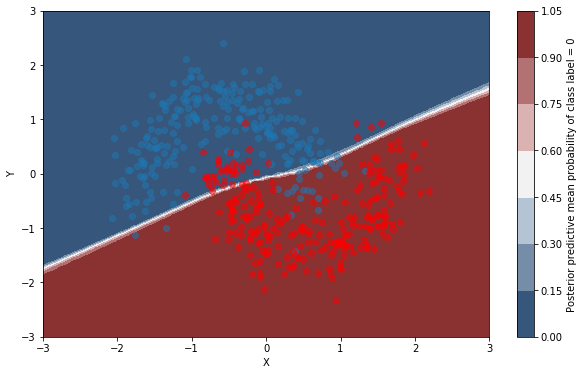

In [38]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

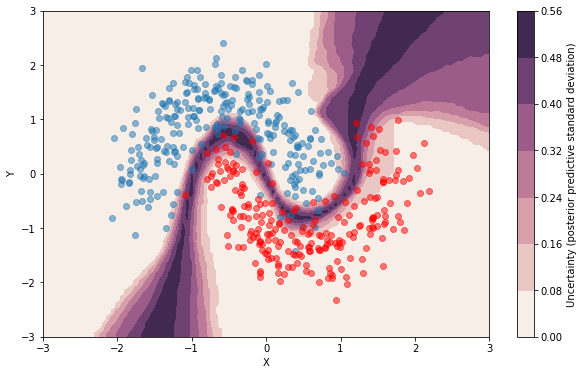

In [18]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [50]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-2



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=True)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon= 2e-1, l2=1e-3, invert_every=1)




n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)
        
        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)

                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1

        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 0.7000
Epoch 1 - loss: 0.6021
Epoch 2 - loss: 0.5897
Epoch 3 - loss: 0.4827
Epoch 4 - loss: 0.4843
Epoch 5 - loss: 0.3945
Epoch 6 - loss: 0.3670
Epoch 7 - loss: 0.3538
Epoch 8 - loss: 0.3667
Epoch 9 - loss: 0.3658
Epoch 10 - loss: 0.4086
Epoch 11 - loss: 0.4525
Epoch 12 - loss: 0.4108
Epoch 13 - loss: 0.4246
Epoch 14 - loss: 0.5218
Epoch 15 - loss: 0.6476
Epoch 16 - loss: 0.5294
Epoch 17 - loss: 0.5818
Accuracy: 0.0000
Epoch 18 - loss: 0.5090
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 19 - loss: 0.6080
Accuracy: 0.0000
Epoch 20 - loss: 0.8376
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 21 - loss: 0.4323
Accuracy: 0.0000
Epoch 22 - loss: 0.3766
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 23 - loss: 0.3759
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 24 - loss: 0.4001
Accuracy: 0.0000
Epoch 25 - loss: 0.3569
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 26 - loss: 0.3651
Accuracy: 0.0000
Epoch 27 - loss: 0.3644
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 28 - loss: 0.3958
Accuracy: 0.0000
Accuracy

Epoch 198 - loss: 0.2944
Epoch 199 - loss: 0.4151


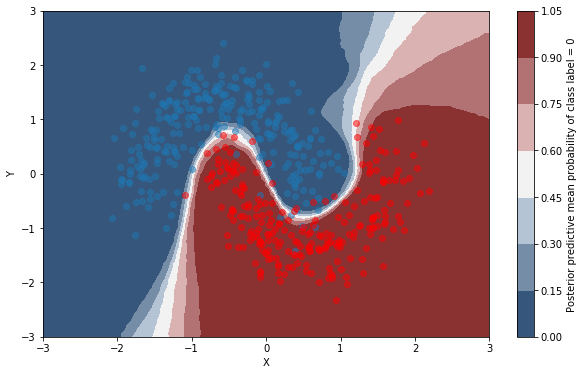

In [19]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

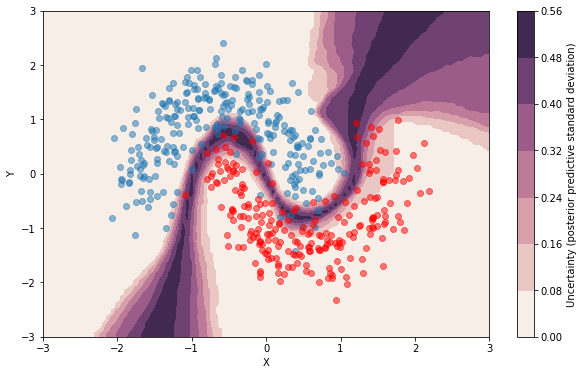

In [20]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');